In [16]:
notebook_path = %pwd

print("Current notebook path:", notebook_path)

Current notebook path: /Users/huangrong/Private/Hui/Sweden/LNU/S2/ProjectInDataIntensive-4DV652/Assignment/deeplearningptoject


In [110]:
import os
import random
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split, KFold, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Lambda, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import register_keras_serializable

In [206]:
# ─── Reproducibility ───────────────────────────────────────────────────────
RANDOM_STATE = 42
os.environ['PYTHONHASHSEED']      = str(RANDOM_STATE)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)


# ─── Configuration ─────────────────────────────────────────────────────────
SCORE_PATH    = 'ML/data/dataset_for_scoring.csv'
SEQUENCE_PATH = 'ML/data/all_kinect_trimmed'
TEST_SIZE     = 0.1

FRAMES      = 48    # fixed frames per sequence
EPOCHS      = 500
ES_PATIENCE = 20    # early-stopping
CV_SPLITS   = 5

param_grid = {
    'conv_filters':  [16],
    'conv_kernel':   [3],
    'pool_size':     [1],
    'lstm_units':    [16],
    'dropout_rate':  [0.0],
    'dense_units':   [[64, 32]],
    'learning_rate': [1e-3],
    'batch_size':    [32],
}


# Augmentation configuration
AUGMENTATION_CONFIG = {
    'rotation': {
        'enabled': True,
        'axis': 'y',  # Y-axis rotation 
        'angle_degrees': 15,  
        'probability': 0.3
    },
    'mirror': {
        'enabled': True,
        'axis': 'x',  # X-axis mirroring with proper joint swapping
        'probability': 0.2  
    },
    'noise': {
        'enabled': False,
        'level': 0.01,  
        'probability': 0.1
    },
    'scale': {
        'enabled': False,
        'min_factor': 1.1,  
        'max_factor': 1.1,
        'probability': 0.4
    }
}

In [79]:
def inspect_joint_structure():
    """
    Inspect the actual joint structure in your data
    """
    # Load column names from a sample file
    sample_file = f"{SEQUENCE_PATH}/A2_kinect.csv"
    df = pd.read_csv(sample_file)
    feature_names = df.drop(columns='FrameNo').columns.tolist()
    
    print("=== Joint Structure Analysis ===")
    print(f"Total features: {len(feature_names)}")
    
    # Find all unique joint names
    joint_names = set()
    for name in feature_names:
        if name.endswith(('_x', '_y', '_z')):
            joint_name = name[:-2]  # Remove '_x', '_y', or '_z'
            joint_names.add(joint_name)
    
    joint_names = sorted(list(joint_names))
    print(f"Found {len(joint_names)} joints:")
    
    # Identify potential left-right pairs
    left_joints = [j for j in joint_names if 'left' in j.lower() or j.lower().startswith('l_')]
    right_joints = [j for j in joint_names if 'right' in j.lower() or j.lower().startswith('r_')]
    
    print(f"\nLeft joints ({len(left_joints)}):")
    for joint in left_joints:
        print(f"  {joint}")
    
    print(f"\nRight joints ({len(right_joints)}):")
    for joint in right_joints:
        print(f"  {joint}")
    
    # Try to identify pairs
    potential_pairs = []
    for left_joint in left_joints:
        # Try different naming conventions
        possible_right_names = [
            left_joint.replace('left', 'right'),
            left_joint.replace('Left', 'Right'),
            left_joint.replace('l_', 'r_'),
            left_joint.replace('L_', 'R_'),
        ]
        
        for right_name in possible_right_names:
            if right_name in right_joints:
                potential_pairs.append((left_joint, right_name))
                break
    
    print(f"\nIdentified {len(potential_pairs)} left-right pairs:")
    for left, right in potential_pairs:
        print(f"  {left} ↔ {right}")
    
    return feature_names, joint_names, potential_pairs

# Run inspection
feature_names, joint_names, joint_pairs = inspect_joint_structure()

=== Joint Structure Analysis ===
Total features: 39
Found 14 joints:

Left joints (6):
  left_elbow
  left_foot
  left_hand
  left_hip
  left_knee
  left_shoulder

Right joints (6):
  right_elbow
  right_foot
  right_hand
  right_hip
  right_knee
  right_shoulder

Identified 6 left-right pairs:
  left_elbow ↔ right_elbow
  left_foot ↔ right_foot
  left_hand ↔ right_hand
  left_hip ↔ right_hip
  left_knee ↔ right_knee
  left_shoulder ↔ right_shoulder


In [123]:
def create_joint_swap_mapping(joint_pairs, feature_names):
    """
    Create detailed mapping for swapping left-right joints
    """
    print("\n=== Creating Joint Swap Mapping ===")
    
    swap_mapping = {}
    successful_pairs = []
    
    for left_joint, right_joint in joint_pairs:
        # Find indices for left joint coordinates
        left_x_idx = None
        left_y_idx = None
        left_z_idx = None
        
        # Find indices for right joint coordinates
        right_x_idx = None
        right_y_idx = None
        right_z_idx = None
        
        for i, name in enumerate(feature_names):
            if name == f"{left_joint}_x":
                left_x_idx = i
            elif name == f"{left_joint}_y":
                left_y_idx = i
            elif name == f"{left_joint}_z":
                left_z_idx = i
            elif name == f"{right_joint}_x":
                right_x_idx = i
            elif name == f"{right_joint}_y":
                right_y_idx = i
            elif name == f"{right_joint}_z":
                right_z_idx = i
        
        # Check if all coordinates exist for both joints
        left_coords = [left_x_idx, left_y_idx, left_z_idx]
        right_coords = [right_x_idx, right_y_idx, right_z_idx]
        
        if all(idx is not None for idx in left_coords + right_coords):
            # Create swapping rules
            # X coordinates: swap and flip sign (mirror effect)
            swap_mapping[left_x_idx] = (right_x_idx, -1.0)
            swap_mapping[right_x_idx] = (left_x_idx, -1.0)
            
            # Y and Z coordinates: swap but keep sign
            swap_mapping[left_y_idx] = (right_y_idx, 1.0)
            swap_mapping[right_y_idx] = (left_y_idx, 1.0)
            swap_mapping[left_z_idx] = (right_z_idx, 1.0)
            swap_mapping[right_z_idx] = (left_z_idx, 1.0)
            
            successful_pairs.append((left_joint, right_joint))
            print(f"✓ Mapped {left_joint} ↔ {right_joint}")
            print(f"  X: {left_x_idx}↔{right_x_idx} (flip), Y: {left_y_idx}↔{right_y_idx}, Z: {left_z_idx}↔{right_z_idx}")
        else:
            print(f"❌ Missing coordinates for {left_joint} ↔ {right_joint}")
            print(f"  Left: x={left_x_idx}, y={left_y_idx}, z={left_z_idx}")
            print(f"  Right: x={right_x_idx}, y={right_y_idx}, z={right_z_idx}")
    
    print(f"\nSuccessfully created mapping for {len(successful_pairs)} joint pairs")
    print(f"Total feature mappings: {len(swap_mapping)}")
    
    return swap_mapping, successful_pairs

# Create the mapping
JOINT_SWAP_MAPPING, SUCCESSFUL_PAIRS = create_joint_swap_mapping(joint_pairs, feature_names)
print("\nJoint swap mapping created successfully!")
print(f"Total mappings: {JOINT_SWAP_MAPPING}")
print("\nMapping details:")



=== Creating Joint Swap Mapping ===
✓ Mapped left_elbow ↔ right_elbow
  X: 6↔12 (flip), Y: 7↔13, Z: 8↔14
✓ Mapped left_foot ↔ right_foot
  X: 33↔36 (flip), Y: 34↔37, Z: 35↔38
✓ Mapped left_hand ↔ right_hand
  X: 15↔18 (flip), Y: 16↔19, Z: 17↔20
✓ Mapped left_hip ↔ right_hip
  X: 21↔24 (flip), Y: 22↔25, Z: 23↔26
✓ Mapped left_knee ↔ right_knee
  X: 27↔30 (flip), Y: 28↔31, Z: 29↔32
✓ Mapped left_shoulder ↔ right_shoulder
  X: 3↔9 (flip), Y: 4↔10, Z: 5↔11

Successfully created mapping for 6 joint pairs
Total feature mappings: 36

Joint swap mapping created successfully!
Total mappings: {6: (12, -1.0), 12: (6, -1.0), 7: (13, 1.0), 13: (7, 1.0), 8: (14, 1.0), 14: (8, 1.0), 33: (36, -1.0), 36: (33, -1.0), 34: (37, 1.0), 37: (34, 1.0), 35: (38, 1.0), 38: (35, 1.0), 15: (18, -1.0), 18: (15, -1.0), 16: (19, 1.0), 19: (16, 1.0), 17: (20, 1.0), 20: (17, 1.0), 21: (24, -1.0), 24: (21, -1.0), 22: (25, 1.0), 25: (22, 1.0), 23: (26, 1.0), 26: (23, 1.0), 27: (30, -1.0), 30: (27, -1.0), 28: (31, 1.0),

In [209]:

# ─── Data Loading & Preprocessing ──────────────────────────────────────────
def load_data(score_path, seq_path):
    """
    Load scoring CSV, drop 'A1', scale Var2 to [0,4], and
    load each Kinect CSV into a list of numpy arrays.
    """
    print(">> Loading data…")
    print(f"   Scoring CSV: {Path(score_path)}")
    print(f"   Kinect CSVs: {Path(seq_path)}\n")
    df = pd.read_csv(Path(score_path))
    df = df[df['filename'] != 'A1']  # drop outlier
    scores = df['Var2'].to_numpy()
    y = scores * (4.0 / scores.max())

    X = []
    for fname in df['filename']:
        path = os.path.join(seq_path, f"{fname}_kinect.csv")
        seq = pd.read_csv(path).drop(columns='FrameNo').to_numpy()
        X.append(seq)
    print(f"   Loaded {len(X)} sequences, targets scaled to [0,4].\n")
    return X, y


def sample_sequence(seq, n_frames=FRAMES):
    """
    Uniformly sample or pad `seq` to exactly `n_frames`.
    If longer, picks evenly spaced frames; if shorter, pads with zeros.
    """
    T, D = seq.shape
    if T >= n_frames:
        idx = np.linspace(0, T - 1, n_frames).round().astype(int)
        return seq[idx]
    pad = np.zeros((n_frames - T, D), dtype=seq.dtype)
    return np.vstack([seq, pad])


def preprocess_and_scale(X, scaler=None):
    """
    Sample/pad each sequence in X to FRAMES, stack them,
    then fit/transform with StandardScaler if needed.
    Returns (X_scaled, scaler).
    """
    arr = np.stack([sample_sequence(s) for s in X], axis=0)
    flat = arr.reshape(-1, arr.shape[-1])
    if scaler is None:
        scaler = StandardScaler().fit(flat)
    scaled = scaler.transform(flat).reshape(arr.shape)
    return scaled, scaler

# ─── Data Augmentation ───────────────────────────────────────────────────────

@register_keras_serializable()
def augment_pose_sequence_with_joint_swap_fixed(x, training=None):
    """
    Comprehensive cascaded data augmentation for pose sequences.
    Applies transformations in order: mirror -> rotation -> scale -> noise
    
    Args:
        x: Input tensor of shape (batch_size, frames, features) or (frames, features)
        training: Boolean indicating if in training mode (passed by Keras)
        
    Returns:
        Augmented tensor with same shape as input
    """
    # Only apply augmentation during training
    if training is False:
        return x
    
    # Start with original data
    x_aug = tf.identity(x)
    
    # ═══════════════════════════════════════════════════════════════════
    # 1. MIRROR AUGMENTATION (with anatomically correct joint swapping)
    # ═══════════════════════════════════════════════════════════════════
    if AUGMENTATION_CONFIG['mirror']['enabled']:
        should_mirror = tf.random.uniform(()) < AUGMENTATION_CONFIG['mirror']['probability']
        print(f"Mirror augmentation enabled: ")
        def apply_mirror():
            # x_mirrored = tf.identity(x_aug)
            # x_list = tf.unstack(x_mirrored, axis=-1)
            
            # # Simple and correct: copy once, read from original, write to copy
            # x_swapped = x_list.copy()
            # for source_idx, (target_idx, sign) in JOINT_SWAP_MAPPING.items():
            #     x_swapped[source_idx] = x_list[target_idx] * tf.cast(sign, x_list[target_idx].dtype)
            
            # return tf.stack(x_swapped, axis=-1)
            x_mirrored = tf.identity(x_aug)
            x_list = tf.unstack(x_mirrored, axis=-1)
            
            # Simple method: flip every X coordinate (indices 0, 3, 6, 9, ...)
            # Assumes format: [joint1_x, joint1_y, joint1_z, joint2_x, joint2_y, joint2_z, ...]
            for i in range(0, len(x_list), 3):  # X coordinates at indices 0, 3, 6, ...
                x_list[i] = -x_list[i]  # Flip sign of X coordinate
            
            return tf.stack(x_list, axis=-1)

        x_aug = tf.cond(should_mirror, apply_mirror, lambda: x_aug)
    # ═══════════════════════════════════════════════════════════════════
    # 2. ROTATION AUGMENTATION (Y-axis rotation)
    # ═══════════════════════════════════════════════════════════════════
    if AUGMENTATION_CONFIG['rotation']['enabled']:
        print(f"rotation augmentation enabled: ")
        should_rotate = tf.random.uniform(()) < AUGMENTATION_CONFIG['rotation']['probability']
        
        def apply_rotation():
            # Random rotation angle in radians
            max_angle = AUGMENTATION_CONFIG['rotation']['angle_degrees'] * np.pi / 180.0
            angle = tf.random.uniform((), -max_angle, max_angle)
            
            cos_angle = tf.cos(angle)
            sin_angle = tf.sin(angle)
            

            rotation_matrix = tf.stack([
                [cos_angle, 0.0, sin_angle],
                [0.0, 1.0, 0.0],
                [-sin_angle, 0.0, cos_angle]
            ])
            
            # Reshape for matrix multiplication
            original_shape = tf.shape(x_aug)
            
            # Group coordinates into (x, y, z) triplets
            n_joints = original_shape[-1] // 3
            x_reshaped = tf.reshape(x_aug, tf.concat([original_shape[:-1], [n_joints, 3]], axis=0))
            
            # Apply rotation to each joint
            x_rotated = tf.matmul(x_reshaped, rotation_matrix)
            
            # Reshape back to original format
            return tf.reshape(x_rotated, original_shape)
        
        x_aug = tf.cond(should_rotate, apply_rotation, lambda: x_aug)
    
    # ═══════════════════════════════════════════════════════════════════
    # 3. SCALE AUGMENTATION (uniform scaling)
    # ═══════════════════════════════════════════════════════════════════
    if AUGMENTATION_CONFIG['scale']['enabled']:
        print(f"scale augmentation enabled: ")
        should_scale = tf.random.uniform(()) < AUGMENTATION_CONFIG['scale']['probability']
        
        def apply_scale():
            min_factor = AUGMENTATION_CONFIG['scale']['min_factor']
            max_factor = AUGMENTATION_CONFIG['scale']['max_factor']
            scale_factor = tf.random.uniform((), min_factor, max_factor)
            
            return x_aug * scale_factor
        
        x_aug = tf.cond(should_scale, apply_scale, lambda: x_aug)
    
    # ═══════════════════════════════════════════════════════════════════
    # 4. NOISE AUGMENTATION (Gaussian noise)
    # ═══════════════════════════════════════════════════════════════════
    if AUGMENTATION_CONFIG['noise']['enabled']:
        print(f"noise augmentation enabled: ")
        should_add_noise = tf.random.uniform(()) < AUGMENTATION_CONFIG['noise']['probability']
        
        def apply_noise():
            noise_level = AUGMENTATION_CONFIG['noise']['level']
            noise = tf.random.normal(tf.shape(x_aug), mean=0.0, stddev=noise_level)
            return x_aug + noise
        
        x_aug = tf.cond(should_add_noise, apply_noise, lambda: x_aug)
    
    return x_aug


# Create a custom Lambda layer that properly passes the training parameter
@register_keras_serializable()
class AugmentationLayer(Layer):
    """Custom layer for data augmentation that properly handles training mode"""
    
    def __init__(self, **kwargs):
        super(AugmentationLayer, self).__init__(**kwargs)
        
    def call(self, inputs, training=None):
        return augment_pose_sequence_with_joint_swap_fixed(inputs, training=training)
    
    def get_config(self):
        return super(AugmentationLayer, self).get_config()


# ─── Updated Model Building Function ──────────────────────────────────────

def build_model(n_features, params, use_augmentation=True):
    """
    Build model with comprehensive cascaded augmentation
    
    Args:
        n_features: Number of input features (should be 39 for your data)
        params: Dictionary of hyperparameters
        use_augmentation: Whether to include augmentation layer
    
    Returns:
        Compiled Keras model
    """
  
    
    K.clear_session()
    
    model = Sequential()
    model.add(Input(shape=(FRAMES, n_features), name='input_layer'))
    
    # Add cascaded augmentation layer using custom layer
    if use_augmentation:
        model.add(AugmentationLayer(name='cascaded_pose_augmentation'))
        print("✅ Augmentation layer added to model")
        print(f"   - Mirror augmentation: {AUGMENTATION_CONFIG['mirror']['enabled']} (prob: {AUGMENTATION_CONFIG['mirror']['probability']})")
        print(f"   - Rotation augmentation: {AUGMENTATION_CONFIG['rotation']['enabled']} (±{AUGMENTATION_CONFIG['rotation']['angle_degrees']}°, prob: {AUGMENTATION_CONFIG['rotation']['probability']})")
        print(f"   - Scale augmentation: {AUGMENTATION_CONFIG['scale']['enabled']} ({AUGMENTATION_CONFIG['scale']['min_factor']}-{AUGMENTATION_CONFIG['scale']['max_factor']}, prob: {AUGMENTATION_CONFIG['scale']['probability']})")
        print(f"   - Noise augmentation: {AUGMENTATION_CONFIG['noise']['enabled']} (σ: {AUGMENTATION_CONFIG['noise']['level']}, prob: {AUGMENTATION_CONFIG['noise']['probability']})")
    else:
        print("⚠️  Augmentation disabled")
    
    # Original architecture
    model.add(Conv1D(params['conv_filters'], params['conv_kernel'],
                     padding='same', activation='relu'))
    model.add(Dropout(params['dropout_rate']))
    model.add(MaxPooling1D(pool_size=params['pool_size']))
    model.add(LSTM(params['lstm_units'],
                   dropout=params['dropout_rate'],
                   recurrent_dropout=params['dropout_rate']))
    model.add(Dropout(params['dropout_rate']))
    
    # Dense layers
    for h in params.get('dense_units', []):
        model.add(Dense(h, activation='relu'))
        model.add(Dropout(params['dropout_rate']))
    model.add(Dense(1, activation='linear'))
    
    model.compile(
        optimizer=Adam(learning_rate=params['learning_rate']),
        loss='mse',
        metrics=['mae']
    )
    return model


def evaluate_params(X, y, params, n_splits=CV_SPLITS):
    """
    Perform K-fold cross-validation for one hyperparameter set.
    Returns arrays of fold MSEs and MAEs.
    """
    mses, maes = [], []
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

    for train_idx, val_idx in kf.split(X):
        X_tr, _  = preprocess_and_scale([X[i] for i in train_idx])
        X_val, _ = preprocess_and_scale([X[i] for i in val_idx], scaler=_)
        y_tr, y_val = y[train_idx], y[val_idx]

        model = build_model(X_tr.shape[-1], params)
        es = EarlyStopping(monitor='val_loss', patience=ES_PATIENCE,
                           restore_best_weights=True)

        model.fit(
            X_tr, y_tr,
            validation_data=(X_val, y_val),
            epochs=EPOCHS,
            batch_size=params['batch_size'],
            callbacks=[es],
            verbose=0
        )
        mse, mae = model.evaluate(X_val, y_val, verbose=0)
        mses.append(mse)
        maes.append(mae)

    return np.array(mses), np.array(maes)


def grid_search_cv(X_train, y_train, param_grid):
    """
    Loop over param_grid, run CV, print progress,
    and at the end report best params with CV stats.
    """
    print(">> Starting grid search…")
    combos = list(ParameterGrid(param_grid))
    best_score = np.inf
    best_params = None
    best_stats = {}

    for i, params in enumerate(combos, start=1):
        rem = len(combos) - i
        print(f"  [{i}/{len(combos)}] {params} — {rem} left")
        mses, maes = evaluate_params(X_train, y_train, params)
        m_mae, s_mae = maes.mean(), maes.std()
        print(f"     mean val MAE = {m_mae:.4f} ± {s_mae:.4f}")

        if m_mae < best_score:
            best_score  = m_mae
            best_params = params
            best_stats = {
                'mse': (mses.mean(), maes.std()),
                'mae': (m_mae,     s_mae)
            }

    mse_m, _ = best_stats['mse']
    mae_m, mae_s = best_stats['mae']
    print("\n*** Grid search complete ***")
    print(f"→ Best params: {best_params}")
    print(f"→ CV MSE: {mse_m:.4f}")
    print(f"→ CV MAE: {mae_m:.4f} ± {mae_s:.4f}\n")
    return best_params


# ─── Metrics & Plotting ────────────────────────────────────────────────────
def compute_metrics(y_true, y_pred):
    """
    Compute (MSE, MAE, Pearson r) between two arrays.
    """
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r, _ = pearsonr(y_true, y_pred)
    return mse, mae, r


def plot_pred_vs_true(ax, y_true, y_pred, title=None):
    """
    On `ax`, scatter y_true vs y_pred with identity line in [0,5].
    """
    ax.scatter(y_true, y_pred, alpha=0.6)
    ax.plot([0, 5], [0, 5], 'k--', label='Ideal')
    ax.set_xlim(0, 5); ax.set_ylim(0, 5)
    ax.set_xlabel("True"); ax.set_ylabel("Pred")
    if title: ax.set_title(title)
    ax.legend()


def bland_altman_plot(ax, y_true, y_pred, title=None):
    """
    On `ax`, draw Bland–Altman: mean on x (0–5), diff on y (−1.5–1.5),
    with zero line, mean line, and 95% CI.
    """
    diff = y_pred - y_true
    mn   = (y_pred + y_true) / 2
    md   = diff.mean()
    sd   = diff.std(ddof=1)

    ax.scatter(mn, diff, alpha=0.6)
    ax.axhline(0, color='black', linewidth=1)
    ax.axhline(md, color='blue', linewidth=1, label=f'Mean ({md:.2f})')
    up, lo = md + 1.96*sd, md - 1.96*sd
    ax.axhline(up, color='blue', linestyle='--', label='95% CI')
    ax.axhline(lo, color='blue', linestyle='--')
    ax.set_xlim(0, 5); ax.set_ylim(-1.5, 1.5)
    ax.set_xlabel("Mean (True+Pred)/2"); ax.set_ylabel("Pred − True")
    if title: ax.set_title(title)
    ax.legend()


def plot_training_history(history):
    """
    Plot side-by-side training vs validation MSE and MAE from history.
    """
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(history.history['loss'],     label='Train MSE')
    ax[0].plot(history.history['val_loss'], label='Val   MSE')
    ax[0].set_title('MSE'); ax[0].set_xlabel('Epoch'); ax[0].legend()
    ax[1].plot(history.history['mae'],      label='Train MAE')
    ax[1].plot(history.history['val_mae'],  label='Val   MAE')
    ax[1].set_title('MAE'); ax[1].set_xlabel('Epoch'); ax[1].legend()
    plt.tight_layout(); plt.show()


def evaluate_and_plot(y_tr, y_pred_tr, y_te, y_pred_te):
    """
    1) True vs Pred side-by-side
    2) Bland–Altman side-by-side
    3) Print Train/Test metrics to console
    """
    # True vs Pred
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    plot_pred_vs_true(ax[0], y_tr,    y_pred_tr, title="True vs Pred (Train)")
    plot_pred_vs_true(ax[1], y_te,    y_pred_te, title="True vs Pred (Test)")
    plt.tight_layout(); plt.show()

    # Bland–Altman
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    bland_altman_plot(ax[0], y_tr,    y_pred_tr, title="Bland-Altman (Train)")
    bland_altman_plot(ax[1], y_te,    y_pred_te, title="Bland-Altman (Test)")
    plt.tight_layout(); plt.show()

    # Print metrics
    tr_mse, tr_mae, tr_r = compute_metrics(y_tr, y_pred_tr)
    te_mse, te_mae, te_r = compute_metrics(y_te, y_pred_te)
    print(f"\n=== Results ===")
    print(f"{'':<8}{'MSE':>8}{'MAE':>8}{'   r':>8}")
    print(f"{'Train':<8}{tr_mse:8.4f}{tr_mae:8.4f}{tr_r:8.4f}")
    print(f"{'Test':<8}{te_mse:8.4f}{te_mae:8.4f}{te_r:8.4f}\n")


# ─── Final Training & Saving ──────────────────────────────────────────────
def train_final_model(X_train, y_train, best_params):
    """
    Train on full development set and return (model, scaler, history).
    """
    print(">> Training final model…")
    X_tr, scaler = preprocess_and_scale(X_train)
    model = build_model(X_tr.shape[-1], best_params)

    es = EarlyStopping(monitor='val_loss',
                       patience=ES_PATIENCE,
                       restore_best_weights=True)

    print(f"Training with augmentation enabled...")
    print(f"Batch size: {best_params['batch_size']}")
    print(f"Early stopping patience: {ES_PATIENCE}")
    print(f"Max epochs: {EPOCHS}")
    print("=" * 50)

    history = model.fit(
        X_tr, y_train,
        validation_split=0.1,
        epochs=EPOCHS,
        batch_size=best_params['batch_size'],
        callbacks=[es],
        verbose=1  # Change from 0 to 1 to see training progress
    )
    
    print("=" * 50)
    print(f"Training completed!")
    print(f"Total epochs trained: {len(history.history['loss'])}")
    print(f"Final training loss: {history.history['loss'][-1]:.4f}")
    print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")
    print(f"Best validation loss: {min(history.history['val_loss']):.4f}")
    
    return model, scaler, history


def final_evaluate(model, scaler, history,
                   X_train, y_train, X_test, y_test, best_params):
    """
    Perform final evaluation: plot history, preprocess,
    predict, and call evaluate_and_plot.
    """
    print(">> Evaluating final model…")
    model.summary()
    plot_training_history(history)

    X_tr, _ = preprocess_and_scale(X_train, scaler=scaler)
    X_te, _ = preprocess_and_scale(X_test,  scaler=scaler)

    y_pred_tr = model.predict(X_tr,
                              batch_size=best_params['batch_size'],
                              verbose=0)[:, 0]
    y_pred_te = model.predict(X_te,
                              batch_size=best_params['batch_size'],
                              verbose=0)[:, 0]

    evaluate_and_plot(y_train, y_pred_tr, y_test, y_pred_te)


def save_model_and_scaler(model, scaler,
                          model_path='models/scorer_model.keras',
                          scaler_path='models/scorer_scaler.pkl'):
    """
    Save Keras model (.keras format) and scaler (.pkl),
    and print confirmation.
    """
    model.save(model_path)
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)

    print("=== Artifacts Saved ===")
    print(f"✅ Model : {model_path}")
    print(f"✅ Scaler: {scaler_path}\n")


# ─── Scoring ──────────────────────────────────────────────

def predict_squat_score(csv_path,
                        model_path='models/scorer_model.keras',
                        scaler_path='models/scorer_scaler.pkl'):
    """
    Load the trained Keras model and scaler from disk, then:
      1. Read csv_path (drop FrameNo)
      2. Uniformly sample/pad to FRAMES frames
      3. Frame‐wise StandardScaler transform
      4. Predict with the model → float score
    """
    # 0) load artifacts
    model = tf.keras.models.load_model(model_path)
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)

    # 1) read & drop
    seq = pd.read_csv(csv_path).drop(columns='FrameNo').to_numpy()

    # 2) sample / pad
    sampled = sample_sequence(seq)            # assumes sample_sequence is in scope

    # 3) scale each frame
    scaled = scaler.transform(sampled)        # (FRAMES, D)

    # 4) add batch dim and predict
    x = np.expand_dims(scaled, axis=0)        # (1, FRAMES, D)
    y_pred = model.predict(x, verbose=0)[0,0]

    return float(y_pred)


def get_actual_score(csv_path, score_csv_path='data/dataset_for_scoring.csv'):
    """
    Given a Kinect CSV filepath, look up its ground-truth Var2 score
    (dropping the 'A1' outlier), scale it into [0,4] exactly as in training,
    and return it as a float.

    Parameters
    ----------
    csv_path : str
        Path to the `<filename>_kinect.csv` you want the true score for.
    score_csv_path : str
        Path to your `dataset_for_scoring.csv` (with columns 'filename' & 'Var2').

    Returns
    -------
    float
        The scaled ground-truth score in [0,4].
    """
    # 1) load scoring table
    df = pd.read_csv(score_csv_path)
    df = df[df['filename'] != 'A1']  # drop the A1 outlier

    # 2) figure out base filename (without "_kinect.csv")
    base = os.path.basename(csv_path)
    if base.endswith('_kinect.csv'):
        fname = base[:-len('_kinect.csv')]
    else:
        fname = os.path.splitext(base)[0]

    # 3) find that row
    row = df[df['filename'] == fname]
    if row.empty:
        raise ValueError(f"No ground-truth entry for '{fname}' in {score_csv_path}")

    # 4) compute exactly the same scale factor as in training
    scale_factor = 4.0 / df['Var2'].max()
    true_score = row['Var2'].iloc[0] * scale_factor

    return float(true_score)

In [ ]:
# Load & split
X_all, y_all = load_data(SCORE_PATH, SEQUENCE_PATH)

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=TEST_SIZE, random_state=RANDOM_STATE
)


>> Loading data…
   Scoring CSV: ML/data/dataset_for_scoring.csv
   Kinect CSVs: ML/data/all_kinect_trimmed

   Loaded 105 sequences, targets scaled to [0,4].

=== First Sequence as Structured DataFrame ===
       head_x   head_y    head_z  left_shoulder_x  left_shoulder_y  \
0    0.017793  0.80927  0.034105         -0.14341          0.63360   
1    0.017781  0.80927  0.033843         -0.14332          0.63411   
2    0.017872  0.80924  0.033796         -0.14320          0.63453   
3    0.017903  0.80923  0.033641         -0.14318          0.63440   
4    0.018212  0.80883  0.033508         -0.14294          0.63418   
..        ...      ...       ...              ...              ...   
234  0.044538  0.82553 -0.064939         -0.12719          0.61249   
235  0.044320  0.82561 -0.063343         -0.12731          0.61273   
236  0.044240  0.82571 -0.061802         -0.12730          0.61309   
237  0.043864  0.82549 -0.060350         -0.12743          0.61234   
238  0.043412  0.82596 

In [23]:
# Grid search
best_params = grid_search_cv(X_train, y_train, param_grid)

>> Starting grid search…
  [1/1] {'batch_size': 32, 'conv_filters': 16, 'conv_kernel': 3, 'dense_units': [64, 32], 'dropout_rate': 0.0, 'learning_rate': 0.001, 'lstm_units': 16, 'pool_size': 1} — 0 left
     mean val MAE = 0.1458 ± 0.0247

*** Grid search complete ***
→ Best params: {'batch_size': 32, 'conv_filters': 16, 'conv_kernel': 3, 'dense_units': [64, 32], 'dropout_rate': 0.0, 'learning_rate': 0.001, 'lstm_units': 16, 'pool_size': 1}
→ CV MSE: 0.0365
→ CV MAE: 0.1458 ± 0.0247



In [210]:
# Train

model, scaler, history = train_final_model(X_train, y_train, best_params)


>> Training final model…
Mirror augmentation enabled: 
rotation augmentation enabled: 
✅ Augmentation layer added to model
   - Mirror augmentation: True (prob: 0.2)
   - Rotation augmentation: True (±15°, prob: 0.3)
   - Scale augmentation: False (1.1-1.1, prob: 0.4)
   - Noise augmentation: False (σ: 0.01, prob: 0.1)
Mirror augmentation enabled: 
rotation augmentation enabled: 
Mirror augmentation enabled: 
rotation augmentation enabled: 
Mirror augmentation enabled: 
rotation augmentation enabled: 
Mirror augmentation enabled: 
rotation augmentation enabled: 
Mirror augmentation enabled: 
rotation augmentation enabled: 
Mirror augmentation enabled: 
rotation augmentation enabled: 
Mirror augmentation enabled: 
rotation augmentation enabled: 
Mirror augmentation enabled: 
rotation augmentation enabled: 
Mirror augmentation enabled: 
rotation augmentation enabled: 
Mirror augmentation enabled: 
rotation augmentation enabled: 
Training with augmentation enabled...
Batch size: 32
Early 

>> Evaluating final model…


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ cascaded_pose_augmentation      │ (None, 48, 39)         │             0 │
│ (AugmentationLayer)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 48, 16)         │         1,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 48, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 16)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,605 (84.40 KB)

 Trainable params: 7,201 (28.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,404 (56.27 KB)

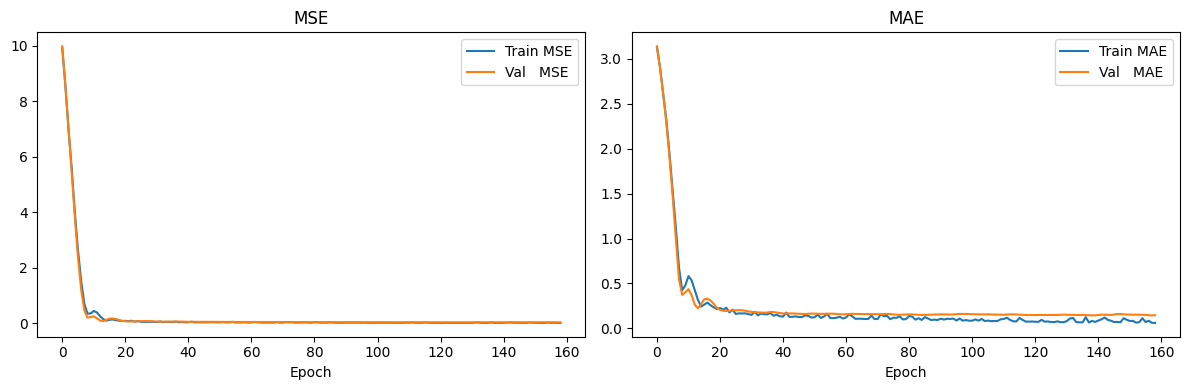

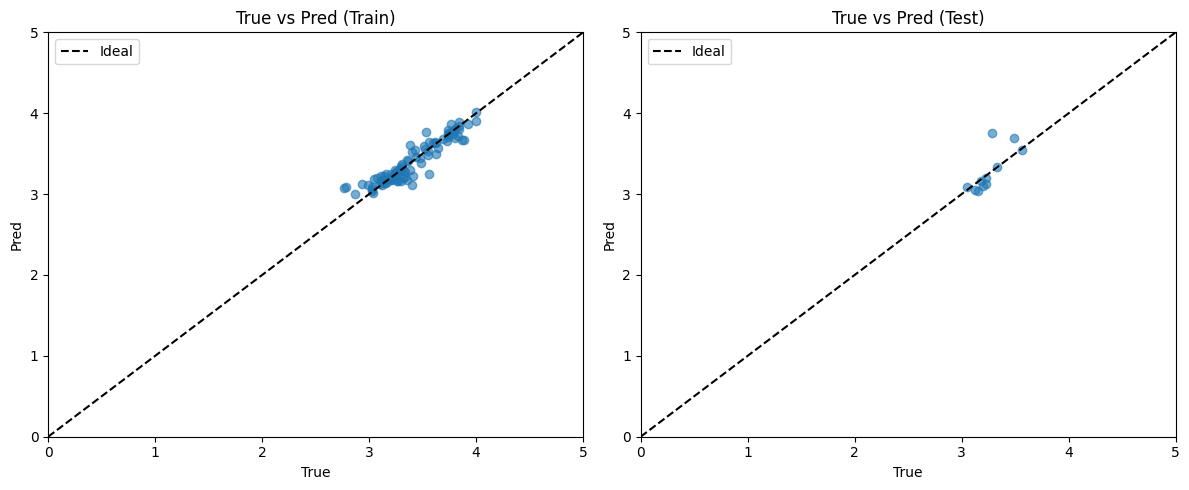

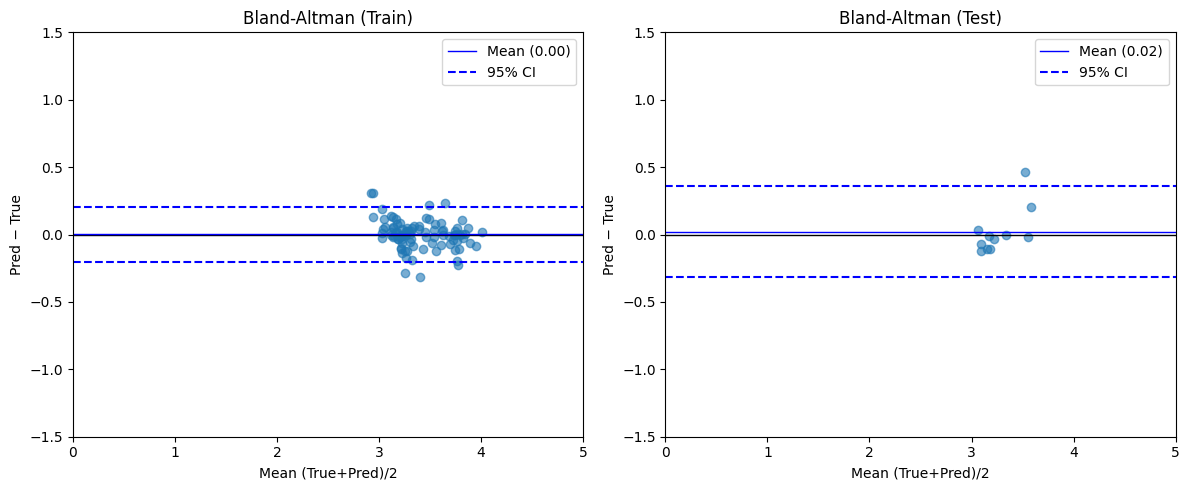


=== Results ===
             MSE     MAE       r
Train     0.0109  0.0735  0.9328
Test      0.0274  0.1068  0.7808



In [211]:
# Evaluate
final_evaluate(
    model, scaler, history,
    X_train, y_train,
    X_test,  y_test,
    best_params
)

In [187]:
# Save
save_model_and_scaler(model, scaler)

=== Artifacts Saved ===
✅ Model : models/scorer_model.keras
✅ Scaler: models/scorer_scaler.pkl



In [190]:
csv_file = 'ML/data/all_kinect_trimmed/A23_kinect.csv'

# predicted:
pred = predict_squat_score(csv_file)
print("Predicted:", pred)

# actual:
actual = get_actual_score(csv_file, SCORE_PATH)
print("Ground truth:", actual)

Predicted: 3.1514711380004883
Ground truth: 3.2613933664152595
